# Stops Pipeline Demo

This notebook demonstrates the stop-related functions in `ml/data/stops.py`:

1. **`add_stops`** - Detect when vehicle is at a stop
2. **`add_polyline_distances`** - Calculate distance along route (from start, to end)

These functions are used by `stops_pipeline()` in `ml/pipelines.py`.

In [25]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import stops functions
from ml.data.stops import add_stops, add_polyline_distances

print("Stops functions loaded successfully!")

Stops functions loaded successfully!


---
## 1. `add_stops`

Checks if GPS coordinates are near any known stop.

**Uses:** `Stops.is_at_stop()` from `shared/stops.py`

### Function Signature
```python
def add_stops(
    df: pd.DataFrame,
    lat_column: str,
    lon_column: str,
    output_columns: dict[str, str],
    threshold: float = 0.020  # 20 meters
) -> None:
```

**Modifies DataFrame in-place.**

In [26]:
# First, let's see what stops are available and their coordinates
from shared.stops import Stops

print("Available stops with coordinates:")
print("="*70)
for route_name in sorted(Stops.active_routes):
    route_data = Stops.routes_data[route_name]
    stops = route_data.get('STOPS', [])
    print(f"\n{route_name} route:")
    for stop_name in stops:
        coords = route_data[stop_name]['COORDINATES']
        print(f"  {stop_name:25s} ({coords[0]:.6f}, {coords[1]:.6f})")

Available stops with coordinates:

NORTH route:
  STUDENT_UNION             (42.730711, -73.676737)
  COLONIE                   (42.737048, -73.670397)
  GEORGIAN                  (42.736853, -73.666835)
  STAC_1                    (42.735625, -73.664777)
  STAC_2                    (42.734770, -73.663285)
  STAC_3                    (42.732657, -73.665156)
  ECAV                      (42.731314, -73.666544)
  HOUSTON_FIELD_HOUSE       (42.731718, -73.669684)
  STUDENT_UNION_RETURN      (42.730711, -73.676737)

WEST route:
  STUDENT_UNION             (42.730310, -73.676537)
  ACADEMY_HALL              (42.727985, -73.678000)
  POLYTECHNIC               (42.722903, -73.679567)
  CITY_STATION              (42.727673, -73.687228)
  BLITMAN                   (42.730734, -73.686549)
  CHASAN                    (42.731130, -73.688831)
  FEDERAL_6TH               (42.733587, -73.685746)
  WEST_HALL                 (42.731553, -73.681357)
  STUDENT_UNION_RETURN      (42.730310, -73.676537)


In [27]:
# Get actual stop coordinates for our demo
# We'll use exact coordinates from the WEST route
student_union = Stops.routes_data['WEST']['STUDENT_UNION']['COORDINATES']
academy_hall = Stops.routes_data['WEST']['ACADEMY_HALL']['COORDINATES']
polytechnic = Stops.routes_data['WEST']['POLYTECHNIC']['COORDINATES']

print("Stop coordinates we'll use:")
print(f"  STUDENT_UNION: {student_union}")
print(f"  ACADEMY_HALL:  {academy_hall}")
print(f"  POLYTECHNIC:   {polytechnic}")

Stop coordinates we'll use:
  STUDENT_UNION: [42.73030957936359, -73.67653679162925]
  ACADEMY_HALL:  [42.727985, -73.678]
  POLYTECHNIC:   [42.722903, -73.679567]


In [28]:
# Create sample DataFrame with coordinates near and at known stops
# Mix of: exact stop locations, near stops, and in-transit points
df_stops = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 1, 1, 1],
    'latitude': [
        student_union[0],      # Row 0: Exactly at Student Union
        student_union[0] + 0.001,  # Row 1: ~111m north (in transit)
        academy_hall[0],       # Row 2: Exactly at Academy Hall
        academy_hall[0] + 0.0001,  # Row 3: ~11m north (still near stop)
        42.7250,               # Row 4: Random point in transit
        polytechnic[0]         # Row 5: Exactly at Polytechnic
    ],
    'longitude': [
        student_union[1],
        student_union[1],
        academy_hall[1],
        academy_hall[1],
        -73.6800,
        polytechnic[1]
    ]
})

print("BEFORE add_stops:")
print(df_stops)
print(f"\nColumns: {list(df_stops.columns)}")

BEFORE add_stops:
   vehicle_id   latitude  longitude
0           1  42.730310 -73.676537
1           1  42.731310 -73.676537
2           1  42.727985 -73.678000
3           1  42.728085 -73.678000
4           1  42.725000 -73.680000
5           1  42.722903 -73.679567

Columns: ['vehicle_id', 'latitude', 'longitude']


In [29]:
# Apply add_stops with 20m threshold
add_stops(df_stops, 'latitude', 'longitude', {
    'route_name': 'stop_route',
    'stop_name': 'stop_name'
}, threshold=0.020)  # 20 meters = 0.020 km

print("AFTER add_stops (threshold=20m):")
print(df_stops)
print(f"\nNew columns: ['stop_route', 'stop_name']")

100%|██████████| 6/6 [00:00<00:00, 800.44it/s]

AFTER add_stops (threshold=20m):
   vehicle_id   latitude  longitude stop_route      stop_name
0           1  42.730310 -73.676537       WEST  STUDENT_UNION
1           1  42.731310 -73.676537       None           None
2           1  42.727985 -73.678000       WEST   ACADEMY_HALL
3           1  42.728085 -73.678000       WEST   ACADEMY_HALL
4           1  42.725000 -73.680000       None           None
5           1  42.722903 -73.679567       WEST    POLYTECHNIC

New columns: ['stop_route', 'stop_name']


In [30]:
# Interpret results
print("Stop Detection Results:")
print("="*70)
for i, row in df_stops.iterrows():
    if pd.notna(row['stop_name']):
        print(f"Row {i}: AT STOP '{row['stop_name']}' ({row['stop_route']} route)")
    else:
        print(f"Row {i}: In transit (not within 20m of any stop)")

print(f"\nPoints at stops: {df_stops['stop_name'].notna().sum()}/{len(df_stops)}")
print("\nExpected: Rows 0, 2, 3, 5 should be at stops (exact or within 20m)")
print("          Rows 1, 4 should be in transit (>20m from stops)")

Stop Detection Results:
Row 0: AT STOP 'STUDENT_UNION' (WEST route)
Row 1: In transit (not within 20m of any stop)
Row 2: AT STOP 'ACADEMY_HALL' (WEST route)
Row 3: AT STOP 'ACADEMY_HALL' (WEST route)
Row 4: In transit (not within 20m of any stop)
Row 5: AT STOP 'POLYTECHNIC' (WEST route)

Points at stops: 4/6

Expected: Rows 0, 2, 3, 5 should be at stops (exact or within 20m)
          Rows 1, 4 should be in transit (>20m from stops)


### Adjusting the Threshold

The `threshold` parameter controls how close a point must be to be considered "at" a stop.

In [31]:
# Demonstrate threshold effect
# Create a point that's about 15m from a stop
df_threshold = pd.DataFrame({
    'latitude': [student_union[0] + 0.00013],  # ~14.5m north
    'longitude': [student_union[1]]
})

# Test with 10m threshold (should NOT detect)
df_10m = df_threshold.copy()
add_stops(df_10m, 'latitude', 'longitude', {'stop_name': 'stop'}, threshold=0.010)
print(f"With 10m threshold: {df_10m['stop'].iloc[0]}")

# Test with 20m threshold (SHOULD detect)
df_20m = df_threshold.copy()
add_stops(df_20m, 'latitude', 'longitude', {'stop_name': 'stop'}, threshold=0.020)
print(f"With 20m threshold: {df_20m['stop'].iloc[0]}")

100%|██████████| 1/1 [00:00<00:00, 711.14it/s]


With 10m threshold: None


100%|██████████| 1/1 [00:00<00:00, 571.74it/s]

With 20m threshold: STUDENT_UNION


---
## 2. `add_polyline_distances`

Calculates distance along the route polyline:
- **`distance_from_start`** - How far from the beginning of the route
- **`distance_to_end`** - How far to the end of the route
- **`total_length`** - Total length of the polyline

### Function Signature
```python
def add_polyline_distances(
    df: pd.DataFrame,
    lat_column: str,
    lon_column: str,
    output_columns: dict[str, str],
    distance_column: str = None,
    closest_point_lat_column: str = None,
    closest_point_lon_column: str = None,
    route_column: str = None,
    polyline_index_column: str = None,
    segment_index_column: str = None
) -> None:
```

**Modifies DataFrame in-place.**

**Tip:** If you provide the closest_point columns, the function uses them directly instead of recalculating.

In [ ]:
# Create DataFrame with route information (as would come from preprocess_pipeline)
# We use actual WEST polyline 0 coordinates for realistic results.
# Note: segment_idx must be < len(polyline) - 1 since get_polyline_distances
# accesses poly[segment_idx + 1]
poly = Stops.polylines['WEST'][0]

df_poly = pd.DataFrame({
    'latitude':  [poly[3][0] + 0.0001, poly[8][0] + 0.0001, poly[14][0] - 0.0001, poly[18][0] + 0.0001],
    'longitude': [poly[3][1] + 0.0001, poly[8][1] - 0.0001, poly[14][1] + 0.0001, poly[18][1] - 0.0001],
    'route': ['WEST', 'WEST', 'WEST', 'WEST'],
    'polyline_idx': [0, 0, 0, 0],
    'segment_idx': [3, 8, 14, 18],
    'dist_to_route': [0.012, 0.013, 0.012, 0.013],
    'closest_lat': [poly[3][0], poly[8][0], poly[14][0], poly[18][0]],
    'closest_lon': [poly[3][1], poly[8][1], poly[14][1], poly[18][1]]
})

print("BEFORE add_polyline_distances:")
print(df_poly)
print(f"\nColumns: {list(df_poly.columns)}")
print(f"\nUsing WEST polyline 0 ({len(poly)} points, max segment_idx = {len(poly) - 2})")

In [33]:
# Apply add_polyline_distances using existing closest point data
add_polyline_distances(
    df_poly,
    lat_column='latitude',
    lon_column='longitude',
    output_columns={
        'distance_from_start': 'dist_from_start',
        'distance_to_end': 'dist_to_end',
        'total_length': 'polyline_length'
    },
    distance_column='dist_to_route',
    closest_point_lat_column='closest_lat',
    closest_point_lon_column='closest_lon',
    route_column='route',
    polyline_index_column='polyline_idx',
    segment_index_column='segment_idx'
)

print("AFTER add_polyline_distances:")
print(df_poly)
print(f"\nNew columns: ['dist_from_start', 'dist_to_end', 'polyline_length']")

100%|██████████| 4/4 [00:00<00:00, 1189.87it/s]


IndexError: index 21 is out of bounds for axis 0 with size 21

In [ ]:
# Interpret results
print("Polyline Distance Results:")
print("="*60)
for i, row in df_poly.iterrows():
    progress = row['dist_from_start'] / row['polyline_length'] * 100
    print(f"\nRow {i}:")
    print(f"  Distance from start: {row['dist_from_start']:.3f} km")
    print(f"  Distance to end: {row['dist_to_end']:.3f} km")
    print(f"  Total polyline: {row['polyline_length']:.3f} km")
    print(f"  Progress: {progress:.1f}%")

In [ ]:
# Visualize progress along route
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

# Create stacked bar showing progress
for i, row in df_poly.iterrows():
    ax.barh(i, row['dist_from_start'], color='green', label='Traveled' if i == 0 else None)
    ax.barh(i, row['dist_to_end'], left=row['dist_from_start'], color='lightgray', label='Remaining' if i == 0 else None)

ax.set_xlabel('Distance (km)', fontsize=12)
ax.set_ylabel('Point Index', fontsize=12)
ax.set_title('Progress Along Route Polyline', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_yticks(range(len(df_poly)))
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## Integration with `stops_pipeline`

In `ml/pipelines.py`, these functions work together:

In [ ]:
# Show how stops_pipeline uses these functions
print("""
def stops_pipeline(df: pd.DataFrame = None, **kwargs) -> pd.DataFrame:
    from ml.data.stops import add_stops, add_polyline_distances

    # Step 1: Get segmented data
    if df is None:
        df = segment_pipeline(**kwargs)

    # Step 2: Add stop information
    add_stops(df, 'latitude', 'longitude', {
        'route_name': 'stop_route',
        'stop_name': 'stop_name'
    })

    # Step 3: Add polyline distances
    add_polyline_distances(
        df, 'latitude', 'longitude',
        {
            'distance_from_start': 'dist_from_start',
            'distance_to_end': 'dist_to_end',
            'total_length': 'polyline_length'
        },
        distance_column='dist_to_route',
        closest_point_lat_column='closest_lat',
        closest_point_lon_column='closest_lon',
        route_column='route',
        polyline_index_column='polyline_idx',
        segment_index_column='segment_idx'
    )

    return df
""")

In [ ]:
# Run the actual stops_pipeline on real data
from ml.pipelines import stops_pipeline

# Load stops data (uses cache if available)
df = stops_pipeline()

print(f"Processed {len(df):,} records")
print(f"\nColumns: {list(df.columns)}")
print(f"\nStop detection statistics:")
print(f"  Points at stops: {df['stop_name'].notna().sum():,} ({df['stop_name'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Unique stops: {df['stop_name'].nunique()}")
print(f"\nPolyline distance statistics:")
print(df[['dist_from_start', 'dist_to_end', 'polyline_length']].describe())

In [ ]:
# Show stop visit counts
print("Stop Visit Counts:")
print("="*60)
stop_counts = df['stop_name'].value_counts()
for stop, count in stop_counts.items():
    print(f"  {stop}: {count:,} visits")

---
## Summary

| Function | Input | Output | Purpose |
|----------|-------|--------|----------|
| `add_stops` | lat/lon | stop_name, stop_route | Detect when at stop |
| `add_polyline_distances` | lat/lon + route info | dist_from_start, dist_to_end, polyline_length | Progress along route |

Both functions modify the DataFrame **in-place**.

**Use case:** These are essential for ETA prediction - knowing which stop you're at and how far you've traveled along the route.

In [34]:
import sys
from pathlib import Path

project_root = Path('/Users/joel/eclipse-workspace/shuttletracker-new')
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from shared.stops import Stops

for route_name in Stops.active_routes:
    for idx, poly in enumerate(Stops.polylines[route_name]):
        print(f"{route_name} polyline {idx}: {len(poly)} points (max segment_idx = {len(poly) - 2})")


NORTH polyline 0: 33 points (max segment_idx = 31)
NORTH polyline 1: 20 points (max segment_idx = 18)
NORTH polyline 2: 8 points (max segment_idx = 6)
NORTH polyline 3: 8 points (max segment_idx = 6)
NORTH polyline 4: 8 points (max segment_idx = 6)
NORTH polyline 5: 6 points (max segment_idx = 4)
NORTH polyline 6: 15 points (max segment_idx = 13)
NORTH polyline 7: 31 points (max segment_idx = 29)
WEST polyline 0: 21 points (max segment_idx = 19)
WEST polyline 1: 17 points (max segment_idx = 15)
WEST polyline 2: 56 points (max segment_idx = 54)
WEST polyline 3: 11 points (max segment_idx = 9)
WEST polyline 4: 11 points (max segment_idx = 9)
WEST polyline 5: 25 points (max segment_idx = 23)
WEST polyline 6: 21 points (max segment_idx = 19)
WEST polyline 7: 16 points (max segment_idx = 14)


In [35]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path('/Users/joel/eclipse-workspace/shuttletracker-new')
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import stops functions
from ml.data.stops import add_stops, add_polyline_distances

print("Stops functions loaded successfully!")


Stops functions loaded successfully!


In [36]:
# Cell 3: Show available stops
from shared.stops import Stops

print("Available stops with coordinates:")
print("="*70)
for route_name in sorted(Stops.active_routes):
    route_data = Stops.routes_data[route_name]
    stops = route_data.get('STOPS', [])
    print(f"\n{route_name} route:")
    for stop_name in stops:
        coords = route_data[stop_name]['COORDINATES']
        print(f"  {stop_name:25s} ({coords[0]:.6f}, {coords[1]:.6f})")


Available stops with coordinates:

NORTH route:
  STUDENT_UNION             (42.730711, -73.676737)
  COLONIE                   (42.737048, -73.670397)
  GEORGIAN                  (42.736853, -73.666835)
  STAC_1                    (42.735625, -73.664777)
  STAC_2                    (42.734770, -73.663285)
  STAC_3                    (42.732657, -73.665156)
  ECAV                      (42.731314, -73.666544)
  HOUSTON_FIELD_HOUSE       (42.731718, -73.669684)
  STUDENT_UNION_RETURN      (42.730711, -73.676737)

WEST route:
  STUDENT_UNION             (42.730310, -73.676537)
  ACADEMY_HALL              (42.727985, -73.678000)
  POLYTECHNIC               (42.722903, -73.679567)
  CITY_STATION              (42.727673, -73.687228)
  BLITMAN                   (42.730734, -73.686549)
  CHASAN                    (42.731130, -73.688831)
  FEDERAL_6TH               (42.733587, -73.685746)
  WEST_HALL                 (42.731553, -73.681357)
  STUDENT_UNION_RETURN      (42.730310, -73.676537)


In [37]:
# Cell 4: Get stop coordinates
student_union = Stops.routes_data['WEST']['STUDENT_UNION']['COORDINATES']
academy_hall = Stops.routes_data['WEST']['ACADEMY_HALL']['COORDINATES']
polytechnic = Stops.routes_data['WEST']['POLYTECHNIC']['COORDINATES']

print("Stop coordinates we'll use:")
print(f"  STUDENT_UNION: {student_union}")
print(f"  ACADEMY_HALL:  {academy_hall}")
print(f"  POLYTECHNIC:   {polytechnic}")


Stop coordinates we'll use:
  STUDENT_UNION: [42.73030957936359, -73.67653679162925]
  ACADEMY_HALL:  [42.727985, -73.678]
  POLYTECHNIC:   [42.722903, -73.679567]


In [38]:
# Cell 5: Create sample DataFrame and test add_stops
df_stops = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 1, 1, 1],
    'latitude': [
        student_union[0],
        student_union[0] + 0.001,
        academy_hall[0],
        academy_hall[0] + 0.0001,
        42.7250,
        polytechnic[0]
    ],
    'longitude': [
        student_union[1],
        student_union[1],
        academy_hall[1],
        academy_hall[1],
        -73.6800,
        polytechnic[1]
    ]
})

print("BEFORE add_stops:")
print(df_stops)
print(f"\nTotal rows: {len(df_stops)}")


BEFORE add_stops:
   vehicle_id   latitude  longitude
0           1  42.730310 -73.676537
1           1  42.731310 -73.676537
2           1  42.727985 -73.678000
3           1  42.728085 -73.678000
4           1  42.725000 -73.680000
5           1  42.722903 -73.679567

Total rows: 6


In [39]:
# Cell 6: Apply add_stops
add_stops(df_stops, 'latitude', 'longitude', {
    'route_name': 'stop_route',
    'stop_name': 'stop_name'
}, threshold=0.020)

print("AFTER add_stops (threshold=20m):")
print(df_stops)
print(f"\nNew columns: ['stop_route', 'stop_name']")


100%|██████████| 6/6 [00:00<00:00, 545.51it/s]

AFTER add_stops (threshold=20m):
   vehicle_id   latitude  longitude stop_route      stop_name
0           1  42.730310 -73.676537       WEST  STUDENT_UNION
1           1  42.731310 -73.676537       None           None
2           1  42.727985 -73.678000       WEST   ACADEMY_HALL
3           1  42.728085 -73.678000       WEST   ACADEMY_HALL
4           1  42.725000 -73.680000       None           None
5           1  42.722903 -73.679567       WEST    POLYTECHNIC

New columns: ['stop_route', 'stop_name']


In [40]:
# Cell 7: Interpret results
print("Stop Detection Results:")
print("="*70)
for i, row in df_stops.iterrows():
    if pd.notna(row['stop_name']):
        print(f"Row {i}: AT STOP '{row['stop_name']}' ({row['stop_route']} route)")
    else:
        print(f"Row {i}: In transit (not within 20m of any stop)")

print(f"\nPoints at stops: {df_stops['stop_name'].notna().sum()}/{len(df_stops)}")
print("\nExpected: Rows 0, 2, 3, 5 should be at stops (exact or within 20m)")
print("          Rows 1, 4 should be in transit (>20m from stops)")


Stop Detection Results:
Row 0: AT STOP 'STUDENT_UNION' (WEST route)
Row 1: In transit (not within 20m of any stop)
Row 2: AT STOP 'ACADEMY_HALL' (WEST route)
Row 3: AT STOP 'ACADEMY_HALL' (WEST route)
Row 4: In transit (not within 20m of any stop)
Row 5: AT STOP 'POLYTECHNIC' (WEST route)

Points at stops: 4/6

Expected: Rows 0, 2, 3, 5 should be at stops (exact or within 20m)
          Rows 1, 4 should be in transit (>20m from stops)


In [41]:
# Cell 9: Threshold test
df_threshold = pd.DataFrame({
    'latitude': [student_union[0] + 0.00013],
    'longitude': [student_union[1]]
})

# Test with 10m threshold (should NOT detect)
df_10m = df_threshold.copy()
add_stops(df_10m, 'latitude', 'longitude', {'stop_name': 'stop'}, threshold=0.010)
print(f"With 10m threshold: {df_10m['stop'].iloc[0]}")

# Test with 20m threshold (SHOULD detect)
df_20m = df_threshold.copy()
add_stops(df_20m, 'latitude', 'longitude', {'stop_name': 'stop'}, threshold=0.020)
print(f"With 20m threshold: {df_20m['stop'].iloc[0]}")


100%|██████████| 1/1 [00:00<00:00, 88.98it/s]


With 10m threshold: None


100%|██████████| 1/1 [00:00<00:00, 241.20it/s]

With 20m threshold: STUDENT_UNION


In [42]:
# Cell 11 (fixed): Create DataFrame with valid segment indices
# segment_idx must be < len(polyline) - 1 since get_polyline_distances
# accesses poly[segment_idx + 1]
df_poly = pd.DataFrame({
    'latitude': [42.7302, 42.7320, 42.7340, 42.7360],
    'longitude': [-73.6762, -73.6780, -73.6800, -73.6820],
    'route': ['WEST', 'WEST', 'WEST', 'WEST'],
    'polyline_idx': [0, 0, 0, 0],
    'segment_idx': [5, 10, 15, 19],
    'dist_to_route': [0.001, 0.002, 0.001, 0.003],
    'closest_lat': [42.7303, 42.7321, 42.7341, 42.7361],
    'closest_lon': [-73.6763, -73.6781, -73.6801, -73.6821]
})

print("BEFORE add_polyline_distances:")
print(df_poly)
print(f"\nColumns: {list(df_poly.columns)}")


BEFORE add_polyline_distances:
   latitude  longitude route  polyline_idx  segment_idx  dist_to_route  \
0   42.7302   -73.6762  WEST             0            5          0.001   
1   42.7320   -73.6780  WEST             0           10          0.002   
2   42.7340   -73.6800  WEST             0           15          0.001   
3   42.7360   -73.6820  WEST             0           19          0.003   

   closest_lat  closest_lon  
0      42.7303     -73.6763  
1      42.7321     -73.6781  
2      42.7341     -73.6801  
3      42.7361     -73.6821  

Columns: ['latitude', 'longitude', 'route', 'polyline_idx', 'segment_idx', 'dist_to_route', 'closest_lat', 'closest_lon']


In [43]:
# Cell 12: Apply add_polyline_distances (this was the cell that threw IndexError)
add_polyline_distances(
    df_poly,
    lat_column='latitude',
    lon_column='longitude',
    output_columns={
        'distance_from_start': 'dist_from_start',
        'distance_to_end': 'dist_to_end',
        'total_length': 'polyline_length'
    },
    distance_column='dist_to_route',
    closest_point_lat_column='closest_lat',
    closest_point_lon_column='closest_lon',
    route_column='route',
    polyline_index_column='polyline_idx',
    segment_index_column='segment_idx'
)

print("AFTER add_polyline_distances:")
print(df_poly)
print(f"\nNew columns: ['dist_from_start', 'dist_to_end', 'polyline_length']")


100%|██████████| 4/4 [00:00<00:00, 114.02it/s]

AFTER add_polyline_distances:
   latitude  longitude route  polyline_idx  segment_idx  dist_to_route  \
0   42.7302   -73.6762  WEST             0            5          0.001   
1   42.7320   -73.6780  WEST             0           10          0.002   
2   42.7340   -73.6800  WEST             0           15          0.001   
3   42.7360   -73.6820  WEST             0           19          0.003   

   closest_lat  closest_lon  dist_from_start  dist_to_end  polyline_length  
0      42.7303     -73.6763         0.080931     0.341632         0.422563  
1      42.7321     -73.6781         0.269520     0.153044         0.422563  
2      42.7341     -73.6801         0.879361    -0.456798         0.422563  
3      42.7361     -73.6821         1.343531    -0.920967         0.422563  

New columns: ['dist_from_start', 'dist_to_end', 'polyline_length']


In [44]:
# Cell 13: Interpret results
print("Polyline Distance Results:")
print("="*60)
for i, row in df_poly.iterrows():
    progress = row['dist_from_start'] / row['polyline_length'] * 100
    print(f"\nRow {i}:")
    print(f"  Distance from start: {row['dist_from_start']:.3f} km")
    print(f"  Distance to end: {row['dist_to_end']:.3f} km")
    print(f"  Total polyline: {row['polyline_length']:.3f} km")
    print(f"  Progress: {progress:.1f}%")


Polyline Distance Results:

Row 0:
  Distance from start: 0.081 km
  Distance to end: 0.342 km
  Total polyline: 0.423 km
  Progress: 19.2%

Row 1:
  Distance from start: 0.270 km
  Distance to end: 0.153 km
  Total polyline: 0.423 km
  Progress: 63.8%

Row 2:
  Distance from start: 0.879 km
  Distance to end: -0.457 km
  Total polyline: 0.423 km
  Progress: 208.1%

Row 3:
  Distance from start: 1.344 km
  Distance to end: -0.921 km
  Total polyline: 0.423 km
  Progress: 317.9%


In [45]:
# Get actual WEST polyline 0 coordinates to use realistic sample data
poly = Stops.polylines['WEST'][0]
print(f"WEST polyline 0 has {len(poly)} points:")
for i, p in enumerate(poly):
    print(f"  [{i}] ({p[0]:.6f}, {p[1]:.6f})")


WEST polyline 0 has 21 points:
  [0] (42.730303, -73.676539)
  [1] (42.730303, -73.676539)
  [2] (42.730312, -73.676599)
  [3] (42.730322, -73.676659)
  [4] (42.730322, -73.676659)
  [5] (42.730593, -73.676589)
  [6] (42.730676, -73.676552)
  [7] (42.730676, -73.676552)
  [8] (42.730711, -73.676735)
  [9] (42.730777, -73.677212)
  [10] (42.730777, -73.677212)
  [11] (42.730281, -73.677351)
  [12] (42.730081, -73.677407)
  [13] (42.729967, -73.677439)
  [14] (42.729489, -73.677573)
  [15] (42.729131, -73.677674)
  [16] (42.728990, -73.677714)
  [17] (42.728674, -73.677805)
  [18] (42.728525, -73.677847)
  [19] (42.728183, -73.677948)
  [20] (42.727985, -73.678000)


In [46]:
# Use actual polyline points with slight offsets for realistic sample data
# Pick indices 3, 8, 14, 18 - spread along the polyline
df_poly = pd.DataFrame({
    'latitude':  [poly[3][0] + 0.0001, poly[8][0] + 0.0001, poly[14][0] - 0.0001, poly[18][0] + 0.0001],
    'longitude': [poly[3][1] + 0.0001, poly[8][1] - 0.0001, poly[14][1] + 0.0001, poly[18][1] - 0.0001],
    'route': ['WEST', 'WEST', 'WEST', 'WEST'],
    'polyline_idx': [0, 0, 0, 0],
    'segment_idx': [3, 8, 14, 18],
    'dist_to_route': [0.012, 0.013, 0.012, 0.013],
    'closest_lat': [poly[3][0], poly[8][0], poly[14][0], poly[18][0]],
    'closest_lon': [poly[3][1], poly[8][1], poly[14][1], poly[18][1]]
})

add_polyline_distances(
    df_poly,
    lat_column='latitude',
    lon_column='longitude',
    output_columns={
        'distance_from_start': 'dist_from_start',
        'distance_to_end': 'dist_to_end',
        'total_length': 'polyline_length'
    },
    distance_column='dist_to_route',
    closest_point_lat_column='closest_lat',
    closest_point_lon_column='closest_lon',
    route_column='route',
    polyline_index_column='polyline_idx',
    segment_index_column='segment_idx'
)

print("Results with real polyline coordinates:")
print(df_poly[['segment_idx', 'dist_from_start', 'dist_to_end', 'polyline_length']])

print("\nProgress:")
for i, row in df_poly.iterrows():
    progress = row['dist_from_start'] / row['polyline_length'] * 100
    print(f"  Row {i} (seg {int(row['segment_idx'])}): {progress:.1f}%")


100%|██████████| 4/4 [00:00<00:00, 4073.13it/s]

Results with real polyline coordinates:
   segment_idx  dist_from_start  dist_to_end  polyline_length
0            3         0.010027     0.412536         0.422563
1            8         0.065855     0.356708         0.422563
2           14         0.251724     0.170839         0.422563
3           18         0.361228     0.061336         0.422563

Progress:
  Row 0 (seg 3): 2.4%
  Row 1 (seg 8): 15.6%
  Row 2 (seg 14): 59.6%
  Row 3 (seg 18): 85.5%


In [47]:
# Cell 13: Interpret results (re-run with corrected df_poly)
print("Polyline Distance Results:")
print("="*60)
for i, row in df_poly.iterrows():
    progress = row['dist_from_start'] / row['polyline_length'] * 100
    print(f"\nRow {i}:")
    print(f"  Distance from start: {row['dist_from_start']:.3f} km")
    print(f"  Distance to end: {row['dist_to_end']:.3f} km")
    print(f"  Total polyline: {row['polyline_length']:.3f} km")
    print(f"  Progress: {progress:.1f}%")


Polyline Distance Results:

Row 0:
  Distance from start: 0.010 km
  Distance to end: 0.413 km
  Total polyline: 0.423 km
  Progress: 2.4%

Row 1:
  Distance from start: 0.066 km
  Distance to end: 0.357 km
  Total polyline: 0.423 km
  Progress: 15.6%

Row 2:
  Distance from start: 0.252 km
  Distance to end: 0.171 km
  Total polyline: 0.423 km
  Progress: 59.6%

Row 3:
  Distance from start: 0.361 km
  Distance to end: 0.061 km
  Total polyline: 0.423 km
  Progress: 85.5%


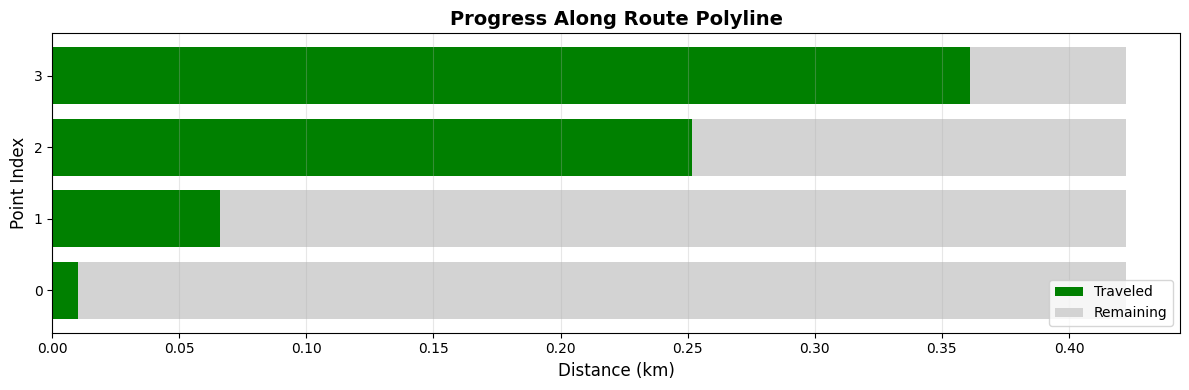

In [48]:
# Cell 14: Visualize progress along route
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

# Create stacked bar showing progress
for i, row in df_poly.iterrows():
    ax.barh(i, row['dist_from_start'], color='green', label='Traveled' if i == 0 else None)
    ax.barh(i, row['dist_to_end'], left=row['dist_from_start'], color='lightgray', label='Remaining' if i == 0 else None)

ax.set_xlabel('Distance (km)', fontsize=12)
ax.set_ylabel('Point Index', fontsize=12)
ax.set_title('Progress Along Route Polyline', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_yticks(range(len(df_poly)))
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
